<a href="https://colab.research.google.com/github/dasaep/W281-ComputerVision-Notebooks/blob/main/CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will see how we can use pre-trained CNN models to extract features which can in-turn be used for image-classification. 

Also given here are two visualization techniques to understand what is being learned by our CNN classifier. The first visualization technique is used to find the importance of the image pixels for classification. The second technique visualizes the filter activation for a given image. 

In [ ]:
import torchvision.models as models
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from skimage.filters import sobel
from skimage.feature import hog
import warnings
warnings.filterwarnings('ignore')

### using pre-trained models for extracting features from images

In [ ]:
# load the model
resnet101 = models.resnet101(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
# get the netwrok without the classification layer
from torch import nn
from torchsummary import summary

# Dropping output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])
model_conv_features = slice_model(resnet101, to_layer=-1).to('cpu')
summary(model_conv_features, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# define the transform for images
from PIL import Image
from torchvision import transforms
# pre-processing required by ResNext
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

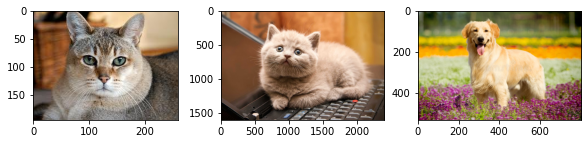

In [ ]:
def read_image(in_url):

  # read the image and convert it to PIL image
  out_im = plt.imread(in_url)[:,:,:3]
  if np.max(out_im)>1:
    out_im = out_im.astype(np.uint8)
  else:
    out_im = (out_im*255.0).astype(np.uint8)
  
  # preprocess the image to prepare it for input to CNN
  out_im = preprocess(Image.fromarray(out_im))

  return out_im

# downlaod the example images
fl = ['https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat1.png',
      'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat2.png',
      'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/dog1.png']

img1_cat = read_image(fl[0])
img2_cat = read_image(fl[1])
img1_dog = read_image(fl[2])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2))
ax[0].imshow(plt.imread(fl[0]))
ax[1].imshow(plt.imread(fl[1]))
ax[2].imshow(plt.imread(fl[2]))

In [ ]:
# put the model in evaluation mode 
resnet101.eval()

# extract the embeddings for the three images
emb1_cat = model_conv_features(img1_cat.unsqueeze(0).to('cpu')).squeeze()
print(emb1_cat.shape)

emb2_cat = model_conv_features(img2_cat.unsqueeze(0).to('cpu')).squeeze()
emb1_dog = model_conv_features(img1_dog.unsqueeze(0).to('cpu')).squeeze()


torch.Size([2048])


In [ ]:

# cosine similarity between the images
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

cat_cat_sim = cos(emb1_cat.unsqueeze(0), emb2_cat.unsqueeze(0))
print('\n Simlarity between cat images: {0:.4}\n'.format(cat_cat_sim.detach().numpy()[0]))

cat_dog_sim = cos(emb1_cat.unsqueeze(0), emb1_dog.unsqueeze(0))
print('\n Simlarity between cat and dog images: {0:.4}\n'.format(cat_dog_sim.detach().numpy()[0]))



 Simlarity between cat images: 0.7046


 Simlarity between cat and dog images: 0.6017



# load the labeled face in wild dataset from sklearn

In [ ]:
# the min_faces_per_person dictates the number of classes
lfw_people = fetch_olivetti_faces()

# the label to predict is the id of the person
y = lfw_people.target

# keep only 20 classes
lfw_people.images = lfw_people.images[y<20, ...]
y = y[y<20]

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

n_classes = len(np.unique(y))

print("Total dataset size:")
print(f"n_samples, height, width: {n_samples}, {h}, {w}")
print("n_classes: %d" % n_classes)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Total dataset size:
n_samples, height, width: 200, 64, 64
n_classes: 20


# extract features from images

In [ ]:
def get_features(in_imgs, feat_name='pixels'):

  if feat_name == 'pixels':
    plt.figure(figsize=(5,5))
    plt.imshow(in_imgs[0, ...], cmap='gray')
    plt.axis('off')
    plt.show()
    return np.vstack([in_imgs[x,:,:].flatten()[np.newaxis, :] for x in range(in_imgs.shape[0])])

  if feat_name == 'sobel':
    out_feat = []
    for i in range(in_imgs.shape[0]):
      sobel_image = sobel(in_imgs[i, :, :])
      if i == 0:
        plt.figure(figsize=(5,5))
        plt.imshow(sobel_image, cmap='gray')
        plt.axis('off')
        plt.show()
      out_feat.append(sobel_image.flatten()[np.newaxis, :])
    return np.vstack(out_feat)
  
  if feat_name == 'hog':
    out_feat = []    
    for i in range(in_imgs.shape[0]):
        fd, hog_image = hog(in_imgs[i, :, :], orientations=4, pixels_per_cell=(8, 8), 
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        if i == 0:
          plt.figure(figsize=(5,5))
          plt.imshow(hog_image, cmap='gray')
          plt.axis('off')
          plt.show()
        out_feat.append(fd[np.newaxis, :])
    return np.vstack(out_feat)

  if feat_name == 'CNN':
    out_feat = []    
    for i in range(in_imgs.shape[0]):

      # convert the grayscale to RGB images
      cur_rgb = np.stack([in_imgs[i,:,:], in_imgs[i,:,:], in_imgs[i,:,:]], axis=2)
      if np.max(cur_rgb)>1:
        cur_rgb = cur_rgb.astype(np.uint8)
      else:
        cur_rgb = (cur_rgb*255).astype(np.uint8)
      
      # preprocess the image to prepare it for input to CNN
      out_im = preprocess(Image.fromarray(cur_rgb))
      out_feat.append(model_conv_features(out_im.unsqueeze(0).to('cpu')).squeeze().detach().numpy())

      if i==0:
        print(out_feat[0].shape)

    return np.stack(out_feat, axis=0)

  return None


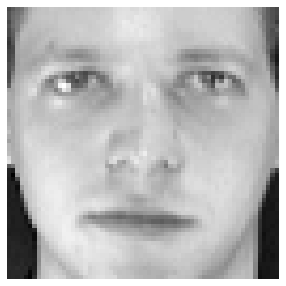

(200, 4096)


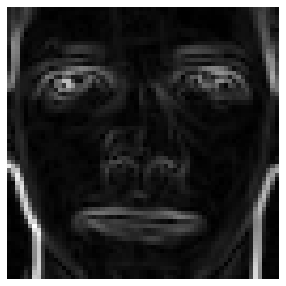

(200, 4096)


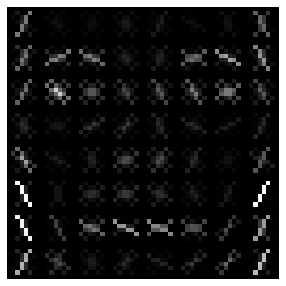

(200, 784)
(2048,)
(200, 2048)


In [ ]:
#features
pixel_features = get_features(lfw_people.images, feat_name='pixels')
print(pixel_features.shape)
sobel_features = get_features(lfw_people.images, feat_name='sobel')
print(sobel_features.shape)
hog_features = get_features(lfw_people.images, feat_name='hog')
print(hog_features.shape)
CNN_features = get_features(lfw_people.images, feat_name='CNN')
print(CNN_features.shape)

# dimensionality reduction

In [ ]:
def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized").fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-', 'g-', 'k-']
  labels = ['pixel features', 'sobel features', 'hog features', 'CNN features']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(b=True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list


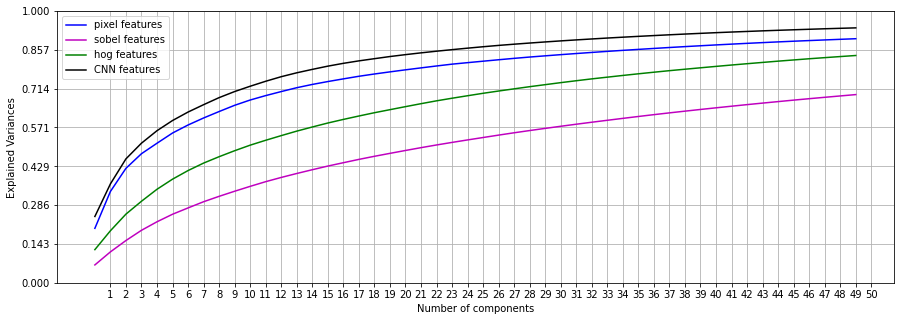

In [ ]:
# plot explained variance vs the number of components for PCA
x = plot_PCA([pixel_features, sobel_features, hog_features, CNN_features], n_components=50)

In [ ]:
# pixel dimensionality reduction (2D)
X_pixels_pca, X_sobel_pca, X_hog_pca, X_CNN_pca = get_PCA([pixel_features, sobel_features, hog_features, CNN_features], n_components=2)[-1]
X_pixels_tsne, X_sobel_tsne, X_hog_tsne, X_CNN_tsne = get_tsne([pixel_features, sobel_features, hog_features, CNN_features], n_components=2)

# plot the features

In [ ]:
def plot_classes(X, y, ax, title):

  colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  for k in range(len(np.unique(y))):
    if X.shape[1] == 2:
      ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])
    else:
      ax.scatter(X[y==k, 0], X[y==k, 1], X[y==k, 2], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

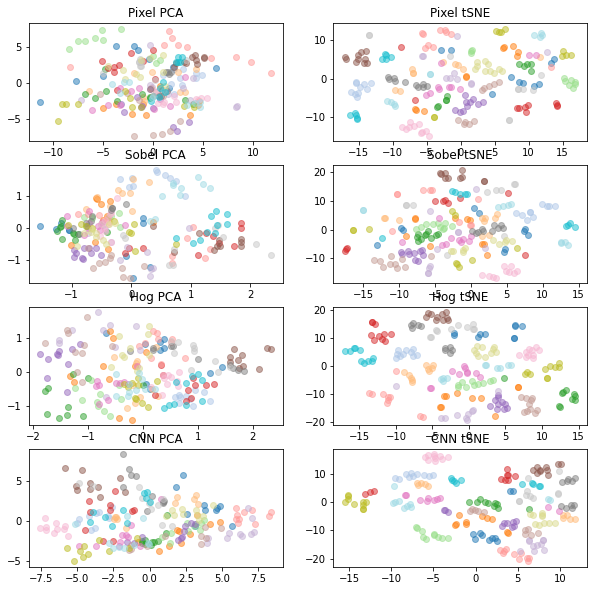

In [ ]:
# project the features into 2 dimensions
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

# y is the class labels
plot_classes(X_pixels_pca, y, ax[0,0], title='Pixel PCA')
plot_classes(X_pixels_tsne, y, ax[0,1], title='Pixel tSNE')
plot_classes(X_sobel_pca, y, ax[1,0], title='Sobel PCA')
plot_classes(X_sobel_tsne, y, ax[1,1], title='Sobel tSNE')
plot_classes(X_hog_pca, y, ax[2,0], title='Hog PCA')
plot_classes(X_hog_tsne, y, ax[2,1], title='Hog tSNE')
plot_classes(X_CNN_pca, y, ax[3,0], title='CNN PCA')
plot_classes(X_CNN_tsne, y, ax[3,1], title='CNN tSNE')
plt.show()

In [ ]:
X_pixels_PCA_tsne = get_tsne([get_PCA([pixel_features], n_components=10)[-1][0]], n_components=2)[0]

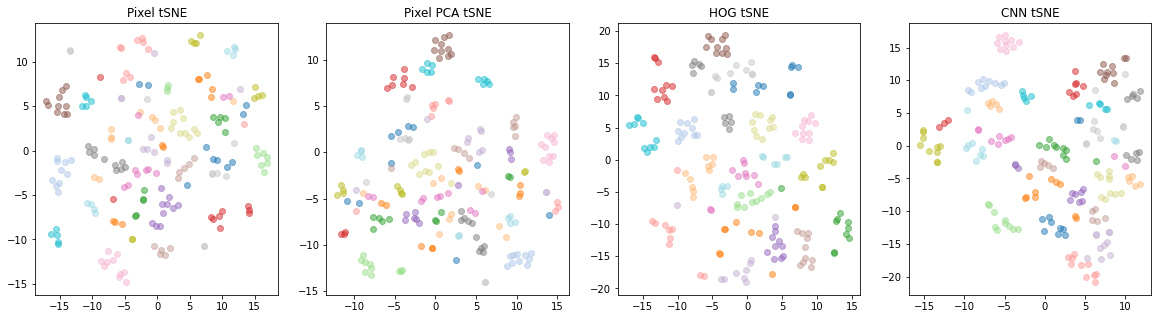

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

# y is the class labels
plot_classes(X_pixels_tsne, y, ax[0], title='Pixel tSNE')
plot_classes(X_pixels_PCA_tsne, y, ax[1], title='Pixel PCA tSNE')
plot_classes(X_hog_tsne, y, ax[2], title='HOG tSNE')
plot_classes(X_CNN_tsne, y, ax[3], title='CNN tSNE')
plt.show()

# Classification

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import loguniform


In [ ]:

# get the train and test split
train_idx, val_idx = train_test_split(np.arange(len(lfw_people.images)), test_size=0.25, random_state=42)


In [ ]:

def train_classifier(in_feat, in_y, in_train_idx, val_idx):

  # get the train and validation split
  X_train = in_feat[in_train_idx, :].copy()
  y_train = in_y[in_train_idx].copy()
  X_val = in_feat[val_idx, :].copy()
  y_val = in_y[val_idx].copy()

  # scaling
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)

  # classifier with cross validation
  param_grid = {"C": loguniform(1e-3, 1e5)}
  clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=42), param_grid, n_iter=10)
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)

  return accuracy_score(y_val, y_pred)


In [ ]:

print('Pixel Feature Accuracy')
n_components = 20
# get accuracy with different features
pixel_acc = []
for n in range(n_components):
  _, X = get_PCA([pixel_features], n_components=n+1)
  pixel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
pixel_acc.append(train_classifier(pixel_features, y, train_idx, val_idx))

print('HOG Feature Accuracy')
hog_acc = []
for n in range(n_components):
  _, X = get_PCA([hog_features], n_components=n+1)
  hog_acc.append(train_classifier(X[0], y, train_idx, val_idx))
hog_acc.append(train_classifier(hog_features, y, train_idx, val_idx))


print('Sobel Feature Accuracy')
sobel_acc = []
for n in range(n_components):
  _, X = get_PCA([sobel_features], n_components=n+1)
  sobel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
sobel_acc.append(train_classifier(sobel_features, y, train_idx, val_idx))

print('CNN Feature Accuracy')
CNN_acc = []
for n in range(n_components):
  _, X = get_PCA([CNN_features], n_components=n+1)
  CNN_acc.append(train_classifier(X[0], y, train_idx, val_idx))
CNN_acc.append(train_classifier(CNN_features, y, train_idx, val_idx))


Pixel Feature Accuracy
HOG Feature Accuracy
Sobel Feature Accuracy
CNN Feature Accuracy


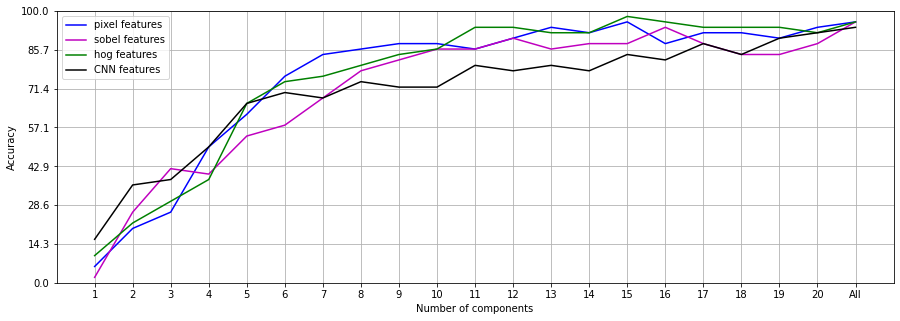

In [ ]:

# plot the accuracy graph
plt.figure(figsize=(15,5))
plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
plt.plot(np.array(sobel_acc)*100, 'm-', label='sobel features')
plt.plot(np.array(hog_acc)*100, 'g-', label='hog features')
plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

xtick_labels = [f'{i+1}' for i in range(n_components)] + ['All']
plt.xticks(np.arange(n_components+1), labels=xtick_labels)
plt.yticks(np.linspace(0, 100, 8))
plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()
